In [ ]:
#!pip install prysm
!pip install rayoptics

In [2]:
#import prysm
import rayoptics

In [3]:
# use standard rayoptics environment
from rayoptics.environment import *

# util functions
from rayoptics.util.misc_math import normalize

In [4]:
from ray_optics_criteria_ITMO import calc_loss

Create a new, empty, model

In [58]:
opm = OpticalModel() # create new model
#opm = open_model('test.roa') # load model from file

sm = opm['seq_model']
osp = opm['optical_spec']
pm = opm['parax_model']
em = opm['ele_model']
pt = opm['part_tree']
ar = opm['analysis_results']

Enter System related attributes

In [59]:
opm.system_spec.title = 'Test Model'
opm.system_spec.dimensions = 'mm'

Specify aperture, field, and wavelengths


In [60]:
# pupil - размер входного зрачка (диафрагмы)
osp['pupil'] = PupilSpec(osp, value=2.5)

# field of view - 'flds' - список точек поля (??), 'value' - maximum field, per the key (?)
# в 'flds' перечислены углы отклонения пучков от оси, по которым мы потом оцениваем качество фокуса на экране
# для лидерборда углы могут меняться
osp['fov'] = FieldSpec(osp, key=['object', 'angle'], is_relative=False, flds=[0., 5., 10., 15., 20.])

# задаём входной диапазон длин волн, нм
osp['wvls'] = WvlSpec([(470, 1.0), (650, 1.0)], ref_wl=1)

Test .roa file params

In [46]:
osp.listobj_str()

'aperture: object pupil; value=2.5\nfield: object angle; value=7.0\nx,y=0.0 vlx= 0.000 vux= 0.000 vly= 0.000 vuy= 0.000\ny=0.25 vly= 0.000 vuy= 0.000 vlx= 0.000 vux= 0.000\ny=0.5 vly= 0.000 vuy= 0.000 vlx= 0.000 vux= 0.000\ny=0.75 vly= 0.000 vuy= 0.000 vlx= 0.000 vux= 0.000\ny=2.0 vly= 0.000 vuy= 0.000 vlx= 0.000 vux= 0.000\ncentral wavelength=650.0 nm\nwavelength (weight) =  470.0000 (1.000),  650.0000 (1.000)*\nfocus shift=0.0\n'

Created schema params

In [61]:
osp.listobj_str()

'aperture: object pupil; value=2.5\nfield: object angle; value=20.0\nx,y=0.0 vlx= 0.000 vux= 0.000 vly= 0.000 vuy= 0.000\ny=5.0 vly= 0.000 vuy= 0.000 vlx= 0.000 vux= 0.000\ny=10.0 vly= 0.000 vuy= 0.000 vlx= 0.000 vux= 0.000\ny=15.0 vly= 0.000 vuy= 0.000 vlx= 0.000 vux= 0.000\ny=20.0 vly= 0.000 vuy= 0.000 vlx= 0.000 vux= 0.000\ncentral wavelength=650.0 nm\nwavelength (weight) =  470.0000 (1.000),  650.0000 (1.000)*\nfocus shift=0.0\n'

Define interface and gap data for the sequential model

Test Schema from .roa

In [ ]:
sm.listobj_str()

'0: Obj: dummy\nprofile: Spherical\nc=0.0,   r=0.0\nsurface_od=0\nradius=0.0\nt=10000000000.0 (+1);    medium: air\n\n1 (stop): transmit\nprofile: EvenPolynomial\nc=0.2747823174694503,   r=3.639244363353831   conic cnst=0.0\ncoefficients: [0.0, 0.009109298409282469, -0.03374649200850791, 0.01797256809388843, -0.0050513483804677005, 0.0, 0.0, 0.0]\nsurface_od=1.3159821701196845\nradius=1.3159821701196845\nt=1.0 (+1);    medium: 540.750, user\n\n2: transmit\nprofile: EvenPolynomial\nc=0.13556582944950138,   r=7.376490108611791   conic cnst=0.0\ncoefficients: [0.0, -0.002874728268075267, -0.03373322938525211, 0.004205227876537139, -0.0001705765222318475, 0.0, 0.0, 0.0]\nsurface_od=1.4607610829755018\nradius=1.4607610829755018\nt=0.5 (+1);    medium: air\n\n3: transmit\nprofile: EvenPolynomial\nc=-0.055209803982245384,   r=-18.112725057339173   conic cnst=0.0\ncoefficients: [0.0, -0.0231369463217776, 0.011956554928461116, -0.017782670650182023, 0.004077846642272649, 0.0, 0.0, 0.0]\nsurface

In [ ]:
sm.list_elements()

EvenPolynomial 0.2747823174694503 0.0 EvenPolynomial 0.13556582944950138 0.0 Gap(t=1.0, medium=ModelGlass(nd=1.54, vd=75.0, mat='540.750', cat='user'))
EvenPolynomial -0.055209803982245384 0.0 Spherical -0.2568888474926888 Gap(t=1.0, medium=ModelGlass(nd=1.67, vd=39.0, mat='670.390', cat='user'))


In [ ]:
sm.list_model()

              c            t        medium     mode   zdr      sd
  Obj:     0.000000  1.00000e+10       air             1      0.0000
 Stop:     0.274782      1.00000   540.750             1      1.3160
    2:     0.135566     0.500000       air             1      1.4608
    3:    -0.055210      1.00000   670.390             1      1.4312
    4:    -0.256889      4.21639       air             1      1.6088
  Img:     0.000000      0.00000                       1      1.8364


Created Schema

В первой строчке осталось surface_od=1.0, хотя в оригинале = 0. Сразу после этого в оригинале идёт "radius=0.0", а в созданной этого нет. В первой поверхности также в оригинале есть "radius=1.3159821701196845", а в созданной - нет - так во всех поверхностях.

In [ ]:
sm.listobj_str()

'0: Obj: dummy\nprofile: Spherical\nc=0.0,   r=0.0\nsurface_od=0.0\nt=10000000000.0 (+1);    medium: air\n\n1 (stop): transmit\nprofile: EvenPolynomial\nc=0.2747823174694503,   r=3.639244363353831   conic cnst=0.0\ncoefficients: [0.0, 0.009109298409282469, -0.03374649200850791, 0.01797256809388843, -0.0050513483804677005, 0.0, 0.0, 0.0]\nsurface_od=1.2500000000218745\nt=1 (+1);    medium: 540.750, user\n\n2: transmit\nprofile: EvenPolynomial\nc=0.13556582944950138,   r=7.376490108611791   conic cnst=0.0\ncoefficients: [0.0, -0.002874728268075267, -0.03373322938525211, 0.004205227876537139, -0.0001705765222318475, 0.0, 0.0, 0.0]\nsurface_od=1.212825925234053\nt=0.5 (+1);    medium: air\n\n3: transmit\nprofile: EvenPolynomial\nc=-0.055209803982245384,   r=-18.112725057339173   conic cnst=0.0\ncoefficients: [0.0, -0.0231369463217776, 0.011956554928461116, -0.017782670650182023, 0.004077846642272649, 0.0, 0.0, 0.0]\nsurface_od=1.1203310303872358\nt=1 (+1);    medium: 670.390, user\n\n4: tr

непонятно, откуда берутся коэффициенты (coefs) - их мы тоже подбираем при оптимизации

In [ ]:
sm.list_elements()

EvenPolynomial 0.2747823174694503 0.0 EvenPolynomial 0.13556582944950138 0.0 Gap(t=1, medium=ModelGlass(nd=1.54, vd=75.0, mat='', cat='user'))
EvenPolynomial -0.055209803982245384 0.0 Spherical -0.2568888474926888 Gap(t=1, medium=ModelGlass(nd=1.67, vd=39.0, mat='', cat='user'))


In [62]:
#opm.radius_mode = True
sm.do_apertures = False
sm.gaps[0].thi=1e10


# [curvature, t, 1.('medium' до заяптой), medium (после запятой без нуля на конце)], sd это surface_od,
# 1 surface - lens
curvature_1 = 0.2747823174694503
t_1 = 1
medium_1_1 = 1.540
medium_2_1 = 75.0
sd_1 = 1.3159821701196845
r_1 = 3.639244363353831
coefs_1 = [0.0, 0.009109298409282469, -0.03374649200850791, 0.01797256809388843, -0.0050513483804677005, 0.0, 0.0, 0.0]

sm.add_surface([curvature_1, t_1, medium_1_1, medium_2_1], sd=sd_1)
sm.ifcs[sm.cur_surface].profile = EvenPolynomial(r=r_1, coefs=coefs_1)
sm.ifcs[sm.cur_surface].profile.sd = sd_1

sm.set_stop()

# 2 surface - air
curvature_2 = 0.13556582944950138
t_2 = 0.5
sd_2 = 1.4607610829755018
r_2 = 7.376490108611791
coefs_2 = [0.0, -0.002874728268075267, -0.03373322938525211, 0.004205227876537139, -0.0001705765222318475, 0.0, 0.0, 0.0]

sm.add_surface([curvature_2, t_2], sd=sd_2)
sm.ifcs[sm.cur_surface].profile = EvenPolynomial(r=r_2,
                        coefs=coefs_2)
sm.ifcs[sm.cur_surface].profile.sd = sd_2

# 3 surface - lens
curvature_3 = -0.055209803982245384
t_3 = 1
medium_1_3 = 1.670
medium_2_3 = 39.0
sd_3 = 1.4312127337246845
r_3 = -18.112725057339173
coefs_3 = [0.0, -0.0231369463217776, 0.011956554928461116, -0.017782670650182023, 0.004077846642272649, 0.0, 0.0, 0.0]

sm.add_surface([curvature_3, t_3, medium_1_3, medium_2_3], sd=sd_3)
sm.ifcs[sm.cur_surface].profile = EvenPolynomial(r=r_3,
                        coefs=coefs_3)
sm.ifcs[sm.cur_surface].profile.sd = sd_3

# 4 surface - air
curvature_4 = -0.2568888474926888
t_4 = 4.216392884493065
sd_4 = 1.608772352457493

sm.add_surface([curvature_4, t_4], sd=sd_4)
sm.ifcs[sm.cur_surface].profile.sd = sd_4

# img sd
sd_5 = 1.836373213770605
sm.ifcs[sm.cur_surface + 1].profile.sd = sd_5

Update the model

In [63]:
opm.update_model()

  warnings.warn(msg, RuntimeWarning)

  warnings.warn(msg, RuntimeWarning)



List the sequential model and the first order properties

In [64]:
sm.list_model()

              c            t        medium     mode   zdr      sd
  Obj:     0.000000  1.00000e+10       air             1      1.0000
 Stop:     0.274782      1.00000   540.750             1      1.3160
    2:     0.135566     0.500000       air             1      1.4608
    3:    -0.055210      1.00000   670.390             1      1.4312
    4:    -0.256889      4.21639       air             1      1.6088
  Img:     0.000000      0.00000                       1      1.0000


In [65]:
pm.first_order_data()

efl               5.194
ffl              -4.041
pp1               1.153
bfl               4.325
ppk              0.8686
f/#               2.078
m            -5.194e-10
red          -1.925e+09
obj_dist          1e+10
obj_ang              20
enp_dist             -0
enp_radius         1.25
na obj         1.25e-10
n obj                 1
img_dist          4.325
img_ht             1.89
exp_dist         -2.242
exp_radius        1.607
na img           -0.234
n img                 1
optical invariant        0.455


In [66]:
pt.list_model()

root
├── Object
├── E5
├── E6
└── Image


Draw a lens layout to verify the model

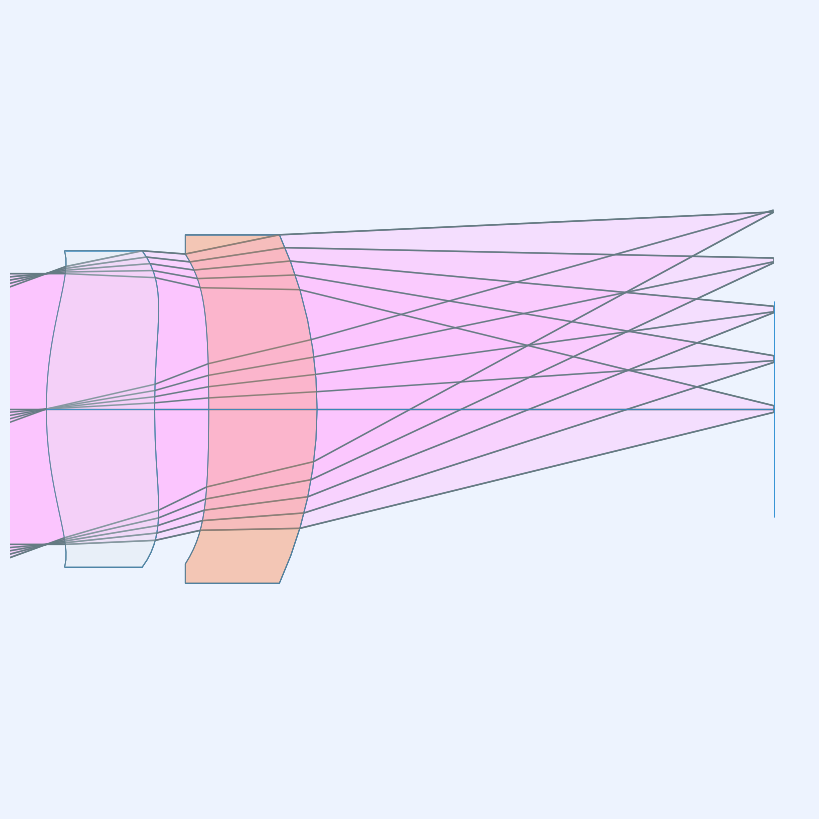

In [67]:
isdark = False

layout_plt0 = plt.figure(FigureClass=InteractiveLayout, opt_model=opm,
                        do_draw_rays=True, do_paraxial_layout=False,
                        is_dark=isdark).plot()

Save Current model

In [68]:
opm.save_model('test_new.roa')

Calc loss metric for optic model

  warnings.warn(msg, RuntimeWarning)

  warnings.warn(msg, RuntimeWarning)

  warnings.warn(msg, RuntimeWarning)

  warnings.warn(msg, RuntimeWarning)



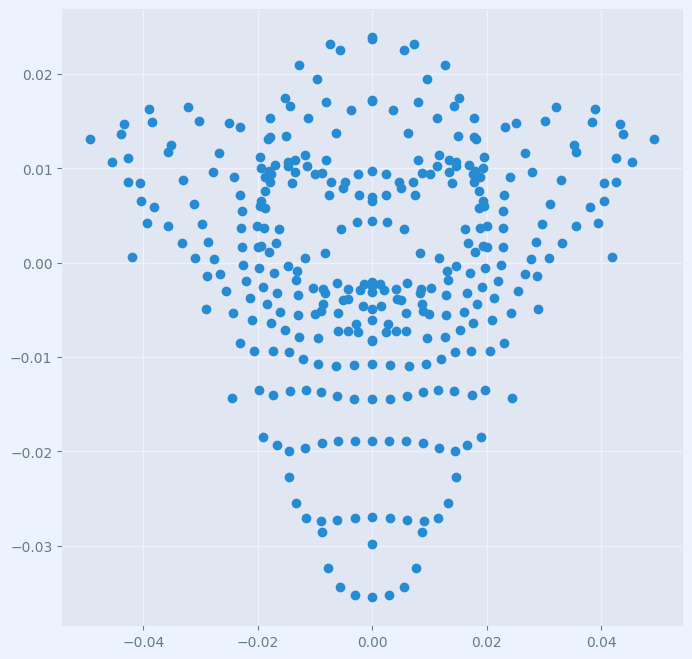

              c            t        medium     mode   zdr      sd
  Obj:     0.000000  1.00000e+10       air             1      1.0000
 Stop:     0.274782      1.00000   540.750             1      1.3160
    2:     0.135566     0.500000       air             1      1.4608
    3:    -0.055210      1.00000   670.390             1      1.4312
    4:    -0.256889      4.21639       air             1      1.6088
  Img:     0.000000      0.00000                       1      1.0000
0 Surface(lbl='Obj', profile=Spherical(c=0.0), interact_mode='dummy')
1 Surface(profile=EvenPolynomial(c=0.2747823174694503, cc=0.0, coefs=[0.0, 0.009109298409282469, -0.03374649200850791, 0.01797256809388843, -0.0050513483804677005, 0.0, 0.0, 0.0]), interact_mode='transmit')
2 Surface(profile=EvenPolynomial(c=0.13556582944950138, cc=0.0, coefs=[0.0, -0.002874728268075267, -0.03373322938525211, 0.004205227876537139, -0.0001705765222318475, 0.0, 0.0, 0.0]), interact_mode='transmit')
3 Surface(profile=EvenPolynomial(

10.655496064325614

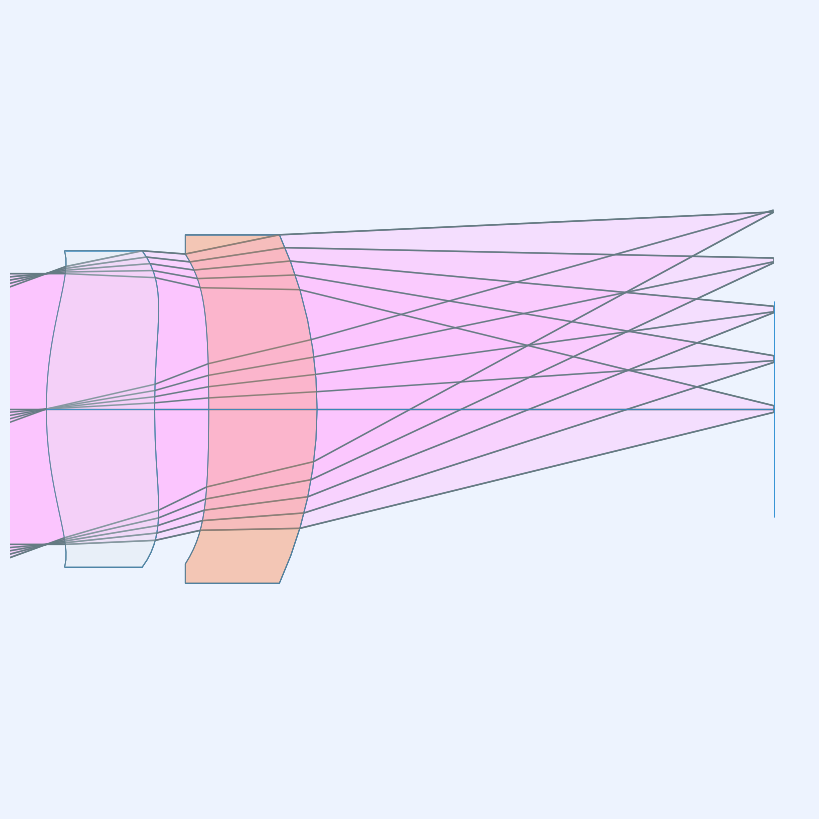

In [69]:
calc_loss('test_new.roa')

Note that in the lens layout above, the very aspheric surface shapes lead to extreme lens element shapes. The default logic used by ray-optics to apply flat bevels to concave surfaces is defeated by the aspherics that switch concavity between vertex and edge. How ray-optics renders flats can be controlled on a surface by surface basis.

First, generate a list of lens elements from the part tree.

In [ ]:
elmn = [node.id for node in pt.nodes_with_tag(tag='#element')]

Lens elements have two surfaces, each of which can be specified with or without a flat.



In [ ]:
elmn[0].sd

1.25

In [ ]:
elmn[0].do_flat1 = 'always'
elmn[0].do_flat2 = 'always'

elmn[1].do_flat1 = 'always'
elmn[1].do_flat2 = 'always'
#elmn[2].do_flat1 = 'always'
#elmn[2].do_flat2 = 'always'
#elmn[3].do_flat1 = 'always'
#elmn[3].do_flat2 = 'always'



By default, the inside diameters of a flat are set to the clear aperture of the interface in the sequential model. This can be overriden for each surface. The semi-diameter sd() of the lens element may also be set explicitly.

In [ ]:
elmn[0].sd = 1.25

elmn[1].sd = 1.75
elmn[1].flat1 = 1.25
elmn[1].flat2 = 1.645

'''
elmn[2].sd = 2.5
elmn[2].flat1 = 2.1

elmn[3].sd = 3.0
elmn[3].flat1 = 2.6

elmn[4].sd = 3.5
'''

'\nelmn[2].sd = 2.5\nelmn[2].flat1 = 2.1\n\nelmn[3].sd = 3.0\nelmn[3].flat1 = 2.6\n\nelmn[4].sd = 3.5\n'

Draw a lens layout to verify the model


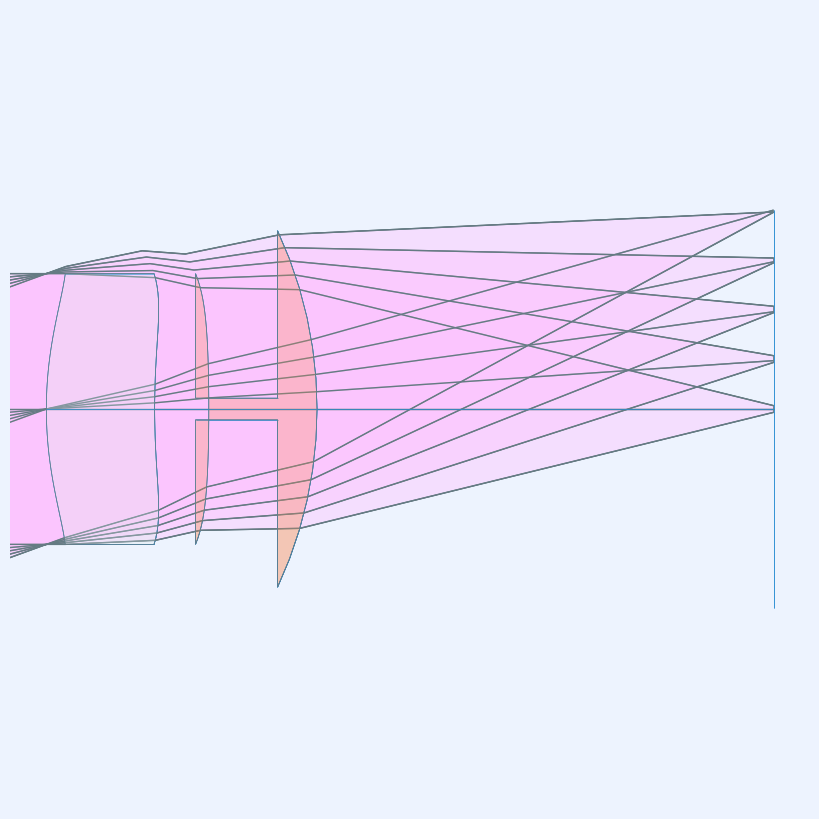

In [ ]:
layout_plt = plt.figure(FigureClass=InteractiveLayout, opt_model=opm,
                        do_draw_rays=True, do_paraxial_layout=False,
                        is_dark=isdark).plot()

Plot a Spot Diagram


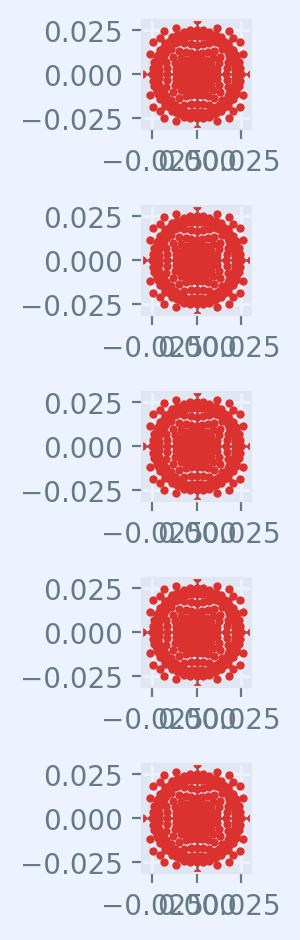

In [ ]:
spot_plt = plt.figure(FigureClass=SpotDiagramFigure, opt_model=opm,
                      scale_type=Fit.All_Same, dpi=200, is_dark=isdark).plot()

Third Order Seidel aberrations

In [ ]:
to_pkg = compute_third_order(opm)
to_pkg

,S-I,S-II,S-III,S-IV,S-V
1,0.011521,0.000585,0.000030,0.000046,3.837474e-06
2,0.000071,0.000028,0.000011,-0.000023,-4.607486e-06
3,-0.002256,0.000239,-0.000025,-0.000010,3.792239e-06
4,0.058583,-0.000620,0.000007,0.000049,-5.868935e-07
sum,0.067919,0.000232,0.000022,0.000062,2.435333e-06


Bar chart for surface by surface third order aberrations


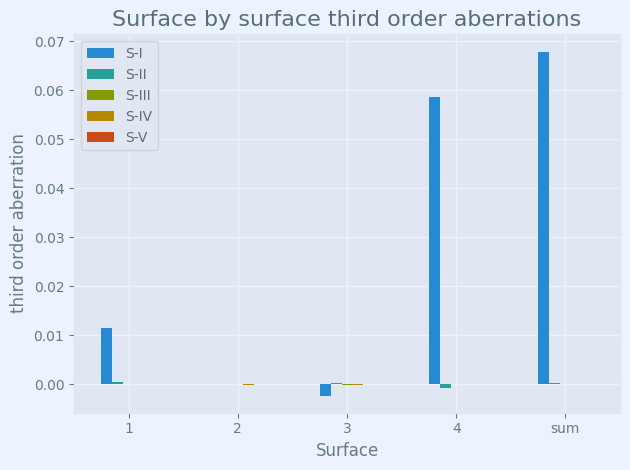

In [ ]:
fig, ax = plt.subplots()
ax.set_xlabel('Surface')
ax.set_ylabel('third order aberration')
ax.set_title('Surface by surface third order aberrations')
to_pkg.plot.bar(ax=ax, rot=0)
ax.grid(True)
fig.tight_layout()

convert aberration sums to transverse measure


In [ ]:
ax_ray, pr_ray, fod = ar['parax_data']
n_last = pm.sys[-1][mc.indx]
u_last = ax_ray[-1][mc.slp]
to.seidel_to_transverse_aberration(to_pkg.loc['sum',:], n_last, u_last)

TSA   -0.006611
TCO   -0.111704
TAS   -0.990128
SAS   -0.353845
PTB   -0.035704
DST   -0.820921
dtype: float64

convert sums to wavefront measure


In [ ]:
central_wv = opm.nm_to_sys_units(sm.central_wavelength())
to.seidel_to_wavefront(to_pkg.loc['sum',:], central_wv).T

W040      0.401816
W131      9.053036
W222     77.351443
W220     43.016183
W311    199.594945
dtype: float64

пока не используется

In [ ]:
# вариант собственной функции потерь
# Определение функции потерь (целевой функции)
def calc_loss(params):
    # Создаем оптическую модель
    opt_model = OpticalModel()

    # Устанавливаем параметры оптической системы из генома
    sm = opt_model.seq_model

    # Добавляем поверхности линз в оптическую модель, используя параметры из генома
    # Здесь вам нужно настроить соответствие между параметрами генома и вашей оптической схемой
    # Пример: curvature, t, 1.('medium' до заяптой), medium (после запятой без нуля на конце), sd это surface_od
    # Примечание: Этот код должен быть адаптирован к вашей оптической системе
    for i, param in enumerate(params):
        curvature, t, medium_1, medium_2, sd, *coefs = param
        sm.add_surface([curvature, t, medium_1, medium_2], sd=sd)
        sm.ifcs[sm.cur_surface].profile = EvenPolynomial(r=0.0, coefs=coefs)
        sm.ifcs[sm.cur_surface].profile.sd = sd

    # Выставляем другие параметры оптической системы (фокусное расстояние, F/# и т.д.)
    # Здесь вы должны убедиться, что ваша система соответствует ограничениям
    opt_model.radius_mode = UOM['mm']
    opt_model.wavelength = 0.55  # Длина волны
    opt_model.optical_spec.field_of_view = 2 * 0.01  # Половина диаметра входного пучка

    # Проводим трассировку лучей и вычисляем MTF
    opt_model.update_model()
    trace, wave, chief_ray, chief_ray_opd, fld, image, row, col = opt_model.trace_base()
    mtf = opt_model.evaluate_mtf()

    # Вычисляем метрику на основе MTF (например, Spot RMS) и возвращаем ее
    metric = ...  # Здесь вычислите метрику на основе MTF и других характеристик
    return metric

Оптимизация параметров генетическим алгоритмом

Change loss from file a little (model object as input and no plots)

In [71]:
import warnings
warnings.filterwarnings('ignore')

In [72]:
import random
from tqdm import tqdm



isdark = False
from matplotlib.colors import LogNorm, PowerNorm, Normalize
from rayoptics.util.misc_math import normalize
import re
import io
from contextlib import redirect_stdout


# base_param
def calc_loss_mute(path2model):
    efl_for_loss=5                      #mm
    fD_for_loss=2.1
    total_length_for_loss=7.0             #mm
    radius_enclosed_energy_for_loss=50    #micron
    perc_max_enclosed_energy_for_loss=80    #%
    perc_min_enclosed_energy_for_loss=50    #%
    min_thickness_for_loss=0.1              #mm
    min_thickness_air_for_loss=0.0            #mm
    number_of_field=5
    number_of_wavelength=2

    def funct_loss_enclosed_energy(enclosed_energy,perc_max_enclosed_energy_for_loss,perc_min_enclosed_energy_for_loss):
        if enclosed_energy<perc_max_enclosed_energy_for_loss:
            if enclosed_energy<perc_min_enclosed_energy_for_loss:
                loss_enclosed_energy=1e3
            else:
                loss_enclosed_energy=(perc_max_enclosed_energy_for_loss-enclosed_energy)
        else:
            loss_enclosed_energy=0
        return loss_enclosed_energy

    def get_thichness(sm):
        f = io.StringIO()
        with redirect_stdout(f):
            sm.list_model()
        s = f.getvalue()
        rows = re.split(r"\n", s)
        thickness_list = []
        thickness_material_list=[]
        thickness_air_list=[]
        for row in rows[1:-1]:
            row = re.sub(r'\s+',r'!', row)
            values = re.split(r"!", row)
            if values[4]!='air' and values[4]!='1':
                thickness_material_list.append(float(values[3]))
            if values[4]=='air' and values[4]!='1':
                thickness_air_list.append(float(values[3]))
            thickness_list.append(float(values[3]))      #3 - thickness, 2 - curvature, 4 - type of material
        number_of_surfaces=len(rows)-2
        return thickness_list, thickness_material_list, thickness_air_list, number_of_surfaces

    opm = open_model(f'{path2model}', info=True)

    sm = opm['seq_model']
    osp = opm['optical_spec']
    pm = opm['parax_model']
    em = opm['ele_model']
    pt = opm['part_tree']
    ar = opm['analysis_results']

    pm.__dict__

    efl=pm.opt_model['analysis_results']['parax_data'].fod.efl
    fD=pm.opt_model['analysis_results']['parax_data'].fod.fno


    ax_ray, pr_ray, fod = ar['parax_data']
    u_last = ax_ray[-1][mc.slp]
    central_wv = opm.nm_to_sys_units(sm.central_wavelength())
    n_last = pm.sys[-1][mc.indx]
    to_df = compute_third_order(opm)

    tr_df=to_df.apply(to.seidel_to_transverse_aberration, axis='columns', args=(n_last,u_last))
    distortion=tr_df.to_numpy()[-1,5]

    field=0
    psf = SpotDiagramFigure(opm)
    test_psf = psf.axis_data_array[field][0][0][0]
    test_psf[:,1]=test_psf[:,1]-np.mean(test_psf[:,1])


    fld, wvl, foc = osp.lookup_fld_wvl_focus(0)
    #sm.list_model()
    #sm.list_surfaces()
    efl=pm.opt_model['analysis_results']['parax_data'].fod.efl

    #pm.first_order_data()
    opm.update_model()

    # total_length=0
    # min_thickness=0.15
    if abs(efl-efl_for_loss)>0.25:
        loss_focus=1e2*(efl-efl_for_loss)**2
    else:
        loss_focus=0

    if abs(fD)>=fD_for_loss:
        loss_FD=5*1e4*(fD-fD_for_loss)**2
    else:
        loss_FD=0


    thickness_list,thickness_material_list,thickness_air_list, number_of_surfaces=get_thichness(sm)
    #print(thickness_list)
    total_length=np.sum(thickness_list[1:])

    min_thickness=np.min(thickness_material_list)
    min_thickness_air=np.min(thickness_air_list)
    if (total_length-total_length_for_loss)>0:
        loss_total_length=1e4*(total_length-total_length_for_loss)**2
    else:
        loss_total_length=0

    if min_thickness<min_thickness_for_loss:
        loss_min_thickness=1e6*(min_thickness-min_thickness_for_loss)**2
    else:
        loss_min_thickness=0

    if min_thickness_air<min_thickness_air_for_loss:
        loss_min_thickness_air=8e4*(min_thickness_air-min_thickness_air_for_loss)**2
    else:
        loss_min_thickness_air=0


    loss_enclosed_energy_all=0
    loss_rms_all=0
    temp=0
    for idx_field in range(number_of_field):
        for idx_wavelength in range(number_of_wavelength):
            test_psf = psf.axis_data_array[idx_field][0][0][idx_wavelength]
            test_psf[:,1]=test_psf[:,1]-np.mean(test_psf[:,1])
            r_psf=np.sort(np.sqrt(test_psf[:,0]**2+test_psf[:,1]**2))
            enclosed_energy=100*np.sum(r_psf<=radius_enclosed_energy_for_loss/1e3)/len(test_psf[:,0])
            loss_enclosed_energy=funct_loss_enclosed_energy(enclosed_energy,perc_max_enclosed_energy_for_loss,perc_min_enclosed_energy_for_loss)
            loss_enclosed_energy_all=loss_enclosed_energy_all+loss_enclosed_energy

            dl=int(np.floor(len(test_psf[:,0])*perc_max_enclosed_energy_for_loss/100))
            loss_rms=np.sqrt(np.sum((1e3*r_psf[:dl])**2)/dl)
            loss_rms_all=loss_rms_all+loss_rms

            temp=temp+1
    loss_enclosed_energy_all=loss_enclosed_energy_all/temp
    loss_rms_all=loss_rms_all/temp
    loss=loss_focus+loss_FD+loss_total_length+loss_min_thickness+loss_min_thickness_air+loss_enclosed_energy_all+loss_rms_all
    return(loss)




# Функция для генерации случайной оптической системы
def generate_random_system():
    system = []

    # Генерация параметров для первой линзы
    curvature_1 = random.uniform(0.1, 0.3)  # Здесь задайте диапазоны параметров
    r_1 = random.uniform(2.0, 5.0)
    system.append(curvature_1)
    system.append(r_1)

    # Генерация параметров для первого слоя воздуха
    curvature_2 = random.uniform(0.01, 0.2)  # Здесь задайте диапазоны параметров
    r_2 = random.uniform(5.0, 9.0)
    system.append(curvature_2)
    system.append(r_2)

    # Генерация параметров для второй линзы
    curvature_3 = random.uniform(-0.2, -0.00001)
    r_3 = random.uniform(-21.0, -16.0)
    system.append(curvature_3)
    system.append(r_3)

    # Генерация параметров для второго слоя воздуха
    curvature_4 = random.uniform(-0.4, -0.01)  # Здесь задайте диапазоны параметров
    system.append(curvature_4)

    return system

# Функция для оценки оптической системы
def evaluate_system(system):
    # Здесь вызывайте вашу функцию calc_loss(), передавая параметры системы
    # и получая метрики качества изображения, например, Encircled Energy и Spot RMS.
    # Затем объедините метрики в одну целевую функцию для оптимизации.
    # Например:
    #encircled_energy = calc_encircled_energy(system)
    #spot_rms = calc_spot_rms(system)

    # Здесь можно взвешать метрики, если необходимо
    #weighted_score = 0.7 * encircled_energy + 0.3 * spot_rms

    opm = OpticalModel() # create new model
    sm = opm['seq_model']
    osp = opm['optical_spec']
    opm.system_spec.title = 'Test Model'
    opm.system_spec.dimensions = 'mm'

    osp['pupil'] = PupilSpec(osp, value=2.5)
    osp['fov'] = FieldSpec(osp, key=['object', 'angle'], is_relative=False, flds=[0., 5., 10., 15., 20.])
    osp['wvls'] = WvlSpec([(470, 1.0), (650, 1.0)], ref_wl=1)

    sm.do_apertures = False
    sm.gaps[0].thi=1e10

    # 1 surface - lens
    curvature_1 = system[0]
    t_1 = 1
    medium_1_1 = 1.540
    medium_2_1 = 75.0
    sd_1 = 1.3159821701196845
    r_1 = system[1]
    coefs_1 = [0.0, 0.009109298409282469, -0.03374649200850791, 0.01797256809388843, -0.0050513483804677005, 0.0, 0.0, 0.0]

    sm.add_surface([curvature_1, t_1, medium_1_1, medium_2_1], sd=sd_1)
    #print(system)
    sm.ifcs[sm.cur_surface].profile = EvenPolynomial(r=r_1, coefs=coefs_1)

    sm.set_stop()

    # 2 surface - air
    curvature_2 = system[2]
    sd_2 = 1.4607610829755018
    t_2 = 0.5
    r_2 = system[3]
    coefs_2 = [0.0, -0.002874728268075267, -0.03373322938525211, 0.004205227876537139, -0.0001705765222318475, 0.0, 0.0, 0.0]

    sm.add_surface([curvature_2, t_2], sd=sd_2)
    sm.ifcs[sm.cur_surface].profile = EvenPolynomial(r=r_2,coefs=coefs_2)

    # 3 surface - lens
    curvature_3 = system[4]
    t_3 = 1
    medium_1_3 = 1.670
    medium_2_3 = 39.0
    sd_3 = 1.4312127337246845
    r_3 = system[5]
    coefs_3 = [0.0, -0.0231369463217776, 0.011956554928461116, -0.017782670650182023, 0.004077846642272649, 0.0, 0.0, 0.0]

    sm.add_surface([curvature_3, t_3, medium_1_3, medium_2_3], sd=sd_3)
    sm.ifcs[sm.cur_surface].profile = EvenPolynomial(r=r_3, coefs=coefs_3)

    # 4 surface - air
    curvature_4 = system[6]
    t_4 = 4.216392884493065
    sd_4 = 1.608772352457493

    sm.add_surface([curvature_4, t_4], sd=sd_4)

    opm.update_model()

    path = 'processing.roa'
    opm.save_model(path)

    return calc_loss_mute(path)

# Оператор селекции для выбора лучших систем
def select_best(population, scores, num_parents):
    sorted_indices = sorted(range(len(scores)), key=lambda i: scores[i])
    parents = [population[i] for i in sorted_indices[:num_parents]]
    return parents

# Оператор скрещивания (кроссовера)
def crossover(parent1, parent2):
    # Здесь можно реализовать различные способы скрещивания параметров
    # линз от двух родителей, например, одноточечное скрещивание.
    crossover_point = random.randint(1, len(parent1) - 1)
    child = parent1[:crossover_point] + parent2[crossover_point:]
    return child

# Оператор мутации
def mutate(system, mutation_rate):
    # Здесь можно реализовать мутацию параметров системы с заданной вероятностью
    for i in range(len(system)):
        if random.random() < mutation_rate:
            # Произведите мутацию для i-й линзы, например, изменение радиуса кривизны или коэффициентов
            if i in [0, 2, 4, 6]:
                system[i] += random.uniform(-0.01, 0.01)  # мутация curvature
            elif i in [1, 3, 5]:
                system[i] += random.uniform(-0.1, 0.1)    # мутация radius

    return system

# Определение параметров ГА
population_size = 40
num_generations = 100
mutation_rate = 0.8
num_parents = 20

# Главный цикл оптимизации
population = [generate_random_system() for _ in range(population_size)]
for generation in tqdm(range(num_generations)):
    scores = [evaluate_system(system) for system in population]
    parents = select_best(population, scores, num_parents)

    new_population = []
    while len(new_population) < population_size:
        parent1, parent2 = random.choice(parents), random.choice(parents)
        child = crossover(parent1, parent2)
        child = mutate(child, mutation_rate)
        new_population.append(child)

    population = new_population

# Найденная оптимальная система будет в population[0]
optimal_system = population[0]

100%|██████████| 100/100 [1:52:31<00:00, 67.52s/it]


In [73]:
population[-1]

[0.12825889026453052,
 3.6316975784616967,
 0.06927974824070138,
 6.5426295940926895,
 0.04404377789300753,
 -19.492963122381823,
 -0.265207235801799]

In [74]:
evaluate_system(population[-1])

15.206630151920908

mut rate 0.8

In [ ]:
evaluate_system(population[-1])

11.47198044559213

In [ ]:
[0.26830148729889425,
 4.397006845745857,
 -0.050038147338059814,
 7.129113617535491,
 -0.015367030821811081,
 -19.585445271638893,
 -0.3053000385203879]